In [1]:
from pathlib import Path
import sys
project_root = next((parent for parent in [Path.cwd()] + list(Path.cwd().parents) if (parent / "pyproject.toml").exists()), Path.cwd())
sys.path.append(str(project_root))

In [2]:
output_path = project_root / "aa2_reasoning.parquet"

In [6]:
from llm_python.datasets.superking import load_superking

superking_df = load_superking()

Bucket: gs://trelis-arc/datasets/superking/
Found 27 parquet files in datasets/superking/
Loading superking dataset...


In [ ]:

from llm_python.datasets.query import filter_soar_df

df = superking_df.copy()
df = filter_soar_df(
    df,
    exclude_subset="arc-prize-2025/evaluation",
    all_train_correct=True,
    all_test_correct=True,
    exclude_transductive=True
)
df = df[df["reasoning"].str.len() > 0]
df = df[df["refined_from_id"].isna()]

In [25]:
import re

def remove_markdown_code_blocks(text):
    # Remove all ```python ... ``` blocks (including newlines)
    return re.sub(r"```python.*?```", "", text, flags=re.DOTALL)

df["reasoning"] = df["reasoning"].apply(remove_markdown_code_blocks).str.strip()

# Filter out rows with empty reasoning
df = df[df["reasoning"].str.len() > 0].reset_index(drop=True)

In [26]:
# Deduplicate df by task_id and code, preferring rows with refined_from_id notna
initial_len = len(df)
df = (
    df.sort_values(by="refined_from_id", na_position="last")  # refined rows first
      .drop_duplicates(subset=["task_id", "code"], keep="first")
      .reset_index(drop=True)
)
print(f"Deduplicated rows: {len(df) } (removed {initial_len - len(df)})")

Deduplicated rows: 21164 (removed 17288)


In [ ]:
import numpy as np

from llm_python.datasets.query import sample_by_task

df["correct_train_input_count"] = df["correct_train_input"].apply(lambda x: np.sum(x))
df["correct_test_input_count"] = df["correct_test_input"].apply(lambda x: np.sum(x))
df["code_length"] = df["code"].str.len()

df = sample_by_task(
    df,
    sort_keys=["correct_test_input_count", "correct_train_input_count"],
    sort_ascending=[False, False],
    task_limit=5,
)

In [28]:
print(len(df))
print(df.head())

2972
                                row_id   task_id  \
9561  acec263aaa009b7f9541439895ccd72a  ff28f65a   
9562  b84c6ed4362e2b31ca00a9a16b163cbb  ff28f65a   
9563  3a1143eeba6ae641e1947eeb54f31298  ff28f65a   
9565  b3e17439dda0c8a91df7a5308b4e40c0  ff28f65a   
513   520622655a78884138b86a218113a379  27a28665   

                                              reasoning  \
9561  We need to infer transformation rule from exam...   
9562  We need to infer transformation: Input grids h...   
9563  We need to infer transformation: Input grids h...   
9565  We need to infer the transformation rule mappi...   
513   **Analyzing color components**\n\nIn input1, t...   

                                                   code  \
9561  def transform(grid):

    h = len(grid)
    w ...   
9562  def transform(grid):

    rows = len(grid)
   ...   
9563  def transform(grid):

    h = len(grid)
    w ...   
9565  def transform(grid):

    rows = len(grid)
   ...   
513   def transform(grid):
    f

In [29]:
from llm_python.datasets.io import write_soar_parquet
from llm_python.datasets.schema import PARQUET_SCHEMA

print(f"Saving final dataset to: {output_path}")
write_soar_parquet(df, output_path, schema=PARQUET_SCHEMA)

Saving final dataset to: /home/lewis/code/trelis-arc/aa2_reasoning.parquet


In [30]:
reasoning_lengths = df["reasoning"].str.len()
deciles = reasoning_lengths.quantile([i / 10 for i in range(11)])
print(deciles)

0.0      870.0
0.1     2986.6
0.2     4395.0
0.3     5734.2
0.4     7203.8
0.5     9147.0
0.6    11609.6
0.7    14847.8
0.8    19580.4
0.9    25779.7
1.0    78147.0
Name: reasoning, dtype: float64


In [31]:
def sample_reasoning_by_length(df, ranges, n_per_range):
    samples = []
    for (low, high), n in zip(ranges, n_per_range):
        subset = df[(df["reasoning"].str.len() >= low) & (df["reasoning"].str.len() < high)]
        if not subset.empty:
            samples.extend(subset.sample(min(n, len(subset)), random_state=42).to_dict("records"))
    return samples

# Define the length ranges and number of samples per range
length_ranges = [(0, 500), (1000, 1500), (20000, 30000)]
n_samples = [2, 2, 2]

samples = sample_reasoning_by_length(df, length_ranges, n_samples)

for s in samples:
    print("===")
    print(f"Task ID: {s['task_id']}")
    print(f"Reasoning length: {len(s['reasoning'])}")
    print(s['reasoning'])

===
Task ID: 68b16354
Reasoning length: 1032
**Analyzing transformation function**

I need to implement a function to transform the grid. It seems the outputs involve some kind of reversal of rows and columns. Looking closely at Input1 and Output1, the transformation looks like a vertical flip or mirror image across a horizontal axis. Each output row corresponds to the original rows flipped: the first output matches the last input row, and this pattern continues down. So it looks like the transformation should simply flip the grid vertically!**Verifying vertical flip transformation**

I'm comparing Input2 and Output2. The rows of Input2, when flipped vertically, match exactly with Output2, confirming that this is indeed a vertical flip. Next, I'm checking Input3, which is a 7x7 grid. Output3 is consistent with the pattern of a vertical flip as well, where each output row corresponds accurately to the reversed input rows. Since both tests confirm this finding, it looks like I can confid

DATASET STATISTICS ANALYSIS: default
1. Computing basic statistics...
📊 Basic Statistics:
   • Unique tasks: 673
   • Total programs: 2,972
   • Fully correct programs: 2,972 (100.0%)
   • Partially correct programs: 0 (0.0%)
   • Completely incorrect programs: 0 (0.0%)
   • Average correctness rate: 1.000

2. Computing per-task distributions...
📈 Per-task Statistics:
   • Average programs per task: 4.4
   • Median programs per task: 5.0
   • Min programs per task: 1
   • Max programs per task: 5
   • Tasks with 5 programs (max): 537
   • Tasks with fully correct programs: 673
   • Tasks with no correct programs: 0

3. Computing quantile distribution of programs per task...
📊 Programs per Task - Quantile Distribution:
   • 0th percentile (min): 1.0
   • 25th percentile: 5.0
   • 50th percentile (median): 5.0
   • 75th percentile: 5.0
   • 90th percentile: 5.0
   • 95th percentile: 5.0
   • 99th percentile: 5.0
   • 100th percentile (max): 5.0

4. Creating visualizations...


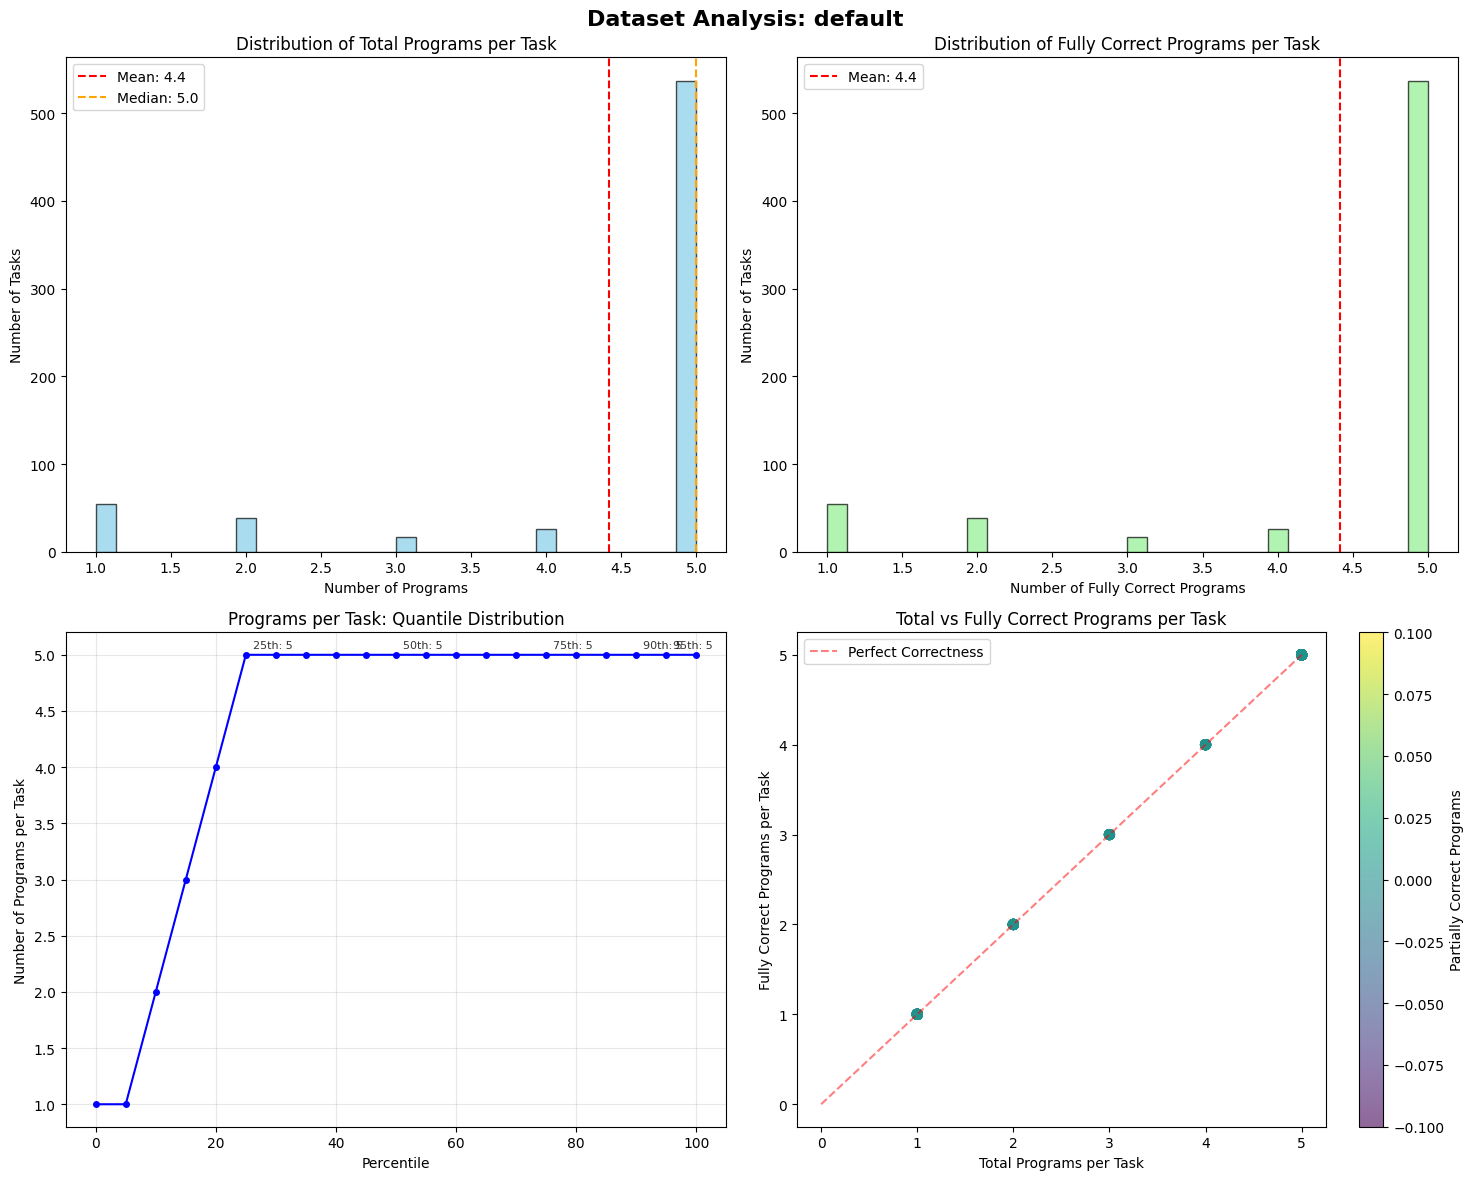


✓ Analysis complete! Generated visualizations showing:
   • Program distribution patterns across tasks
   • Quantile distribution of programs per task
   • Relationship between total and correct programs per task


In [32]:
from llm_python.datasets.statistics import analyze_dataset_statistics

analyze_dataset_statistics(df, "default")